#**Topic modeling with truncatedSVD model**

**Import libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import html
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.decomposition import TruncatedSVD
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import explained_variance_score

**Load dataset**

In [2]:
# Load dataset
df = pd.read_csv("/content/sample-data.csv")

In [3]:
# Load SpaCy model
nlp = spacy.load("en_core_web_sm")

**Text Preprocessing**

In [4]:
# Remove special characters
df["clean_description"] = df["description"].astype(str).apply(lambda x: html.unescape(x))
df["clean_description"] = df["clean_description"].str.replace(r"<.*?>", " ", regex=True)
df["clean_description"] = df["clean_description"].str.replace(r"[^a-zA-Z0-9\s]", " ", regex=True)

In [5]:
# Text preprocessing function
def preprocess_text(text):
    doc = nlp(text.lower())  # Convert to lowercase
    tokens = [token.lemma_ for token in doc if token.text not in STOP_WORDS and token.is_alpha]
    return " ".join(tokens)

# Apply preprocessing
df["clean_description"] = df["clean_description"].apply(preprocess_text)

**Tokenization**

In [6]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df["clean_description"].astype(str))

###**LSA (Latent Semantic Analysis) using TruncatedSVD Model**

In [7]:
# Determine optimal number of topics in range 10-20
best_n_topics = 10
best_score = 0
for n in range(10, 21):
    svd = TruncatedSVD(n_components=n, random_state=42)
    transformed_X = svd.fit_transform(X)
    score = explained_variance_score(X.toarray(), svd.inverse_transform(transformed_X))
    if score > best_score:
        best_n_topics = n
        best_score = score

print(f"Optimal number of topics: {best_n_topics}")

Optimal number of topics: 20


In [8]:
# Apply LSA (Latent Semantic Analysis) using TruncatedSVD with best_n_topics
topic_model = TruncatedSVD(n_components=best_n_topics, random_state=42)
topic_encoded_df = topic_model.fit_transform(X)

In [9]:
# Assign main topic to each document
df["main_topic"] = np.argmax(topic_encoded_df, axis=1)

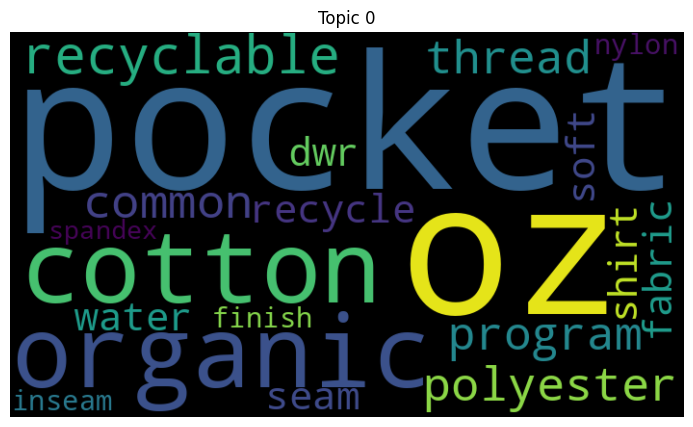

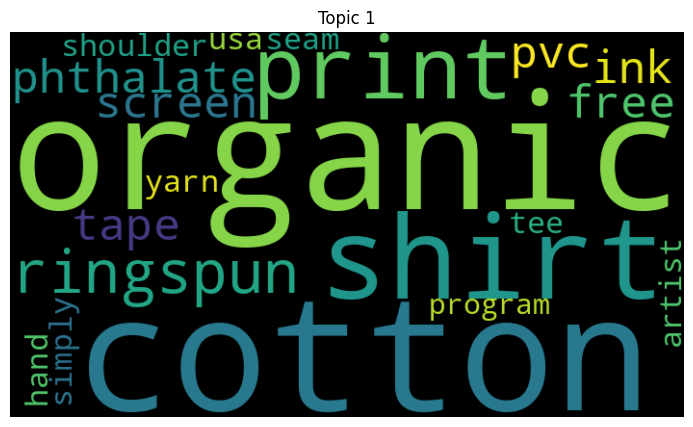

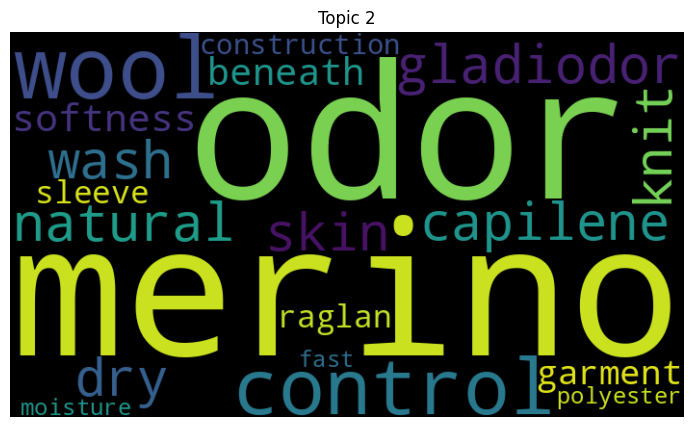

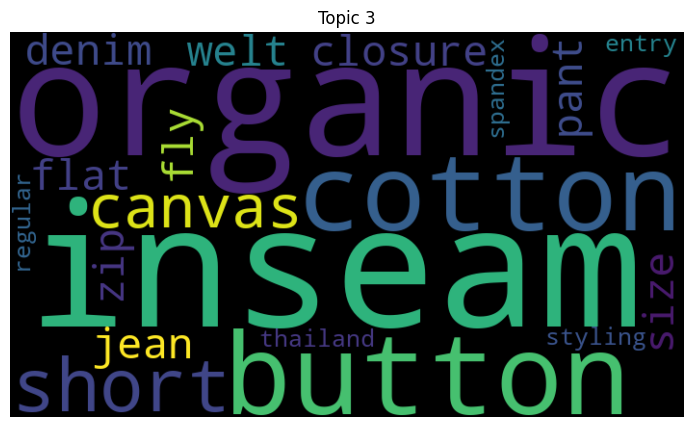

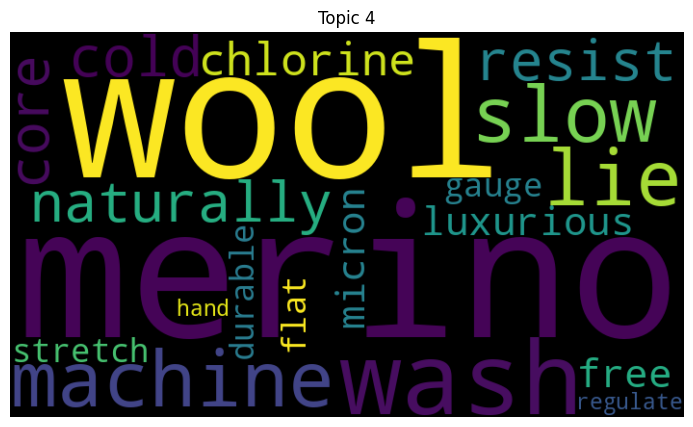

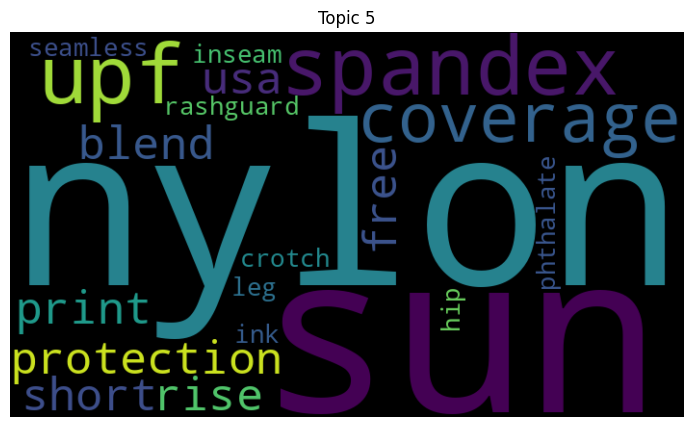

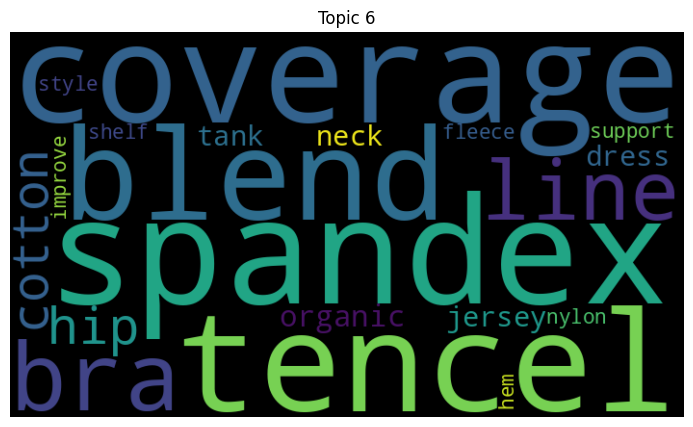

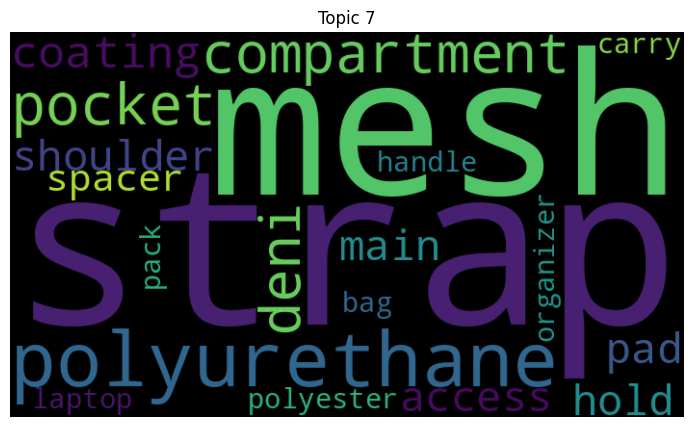

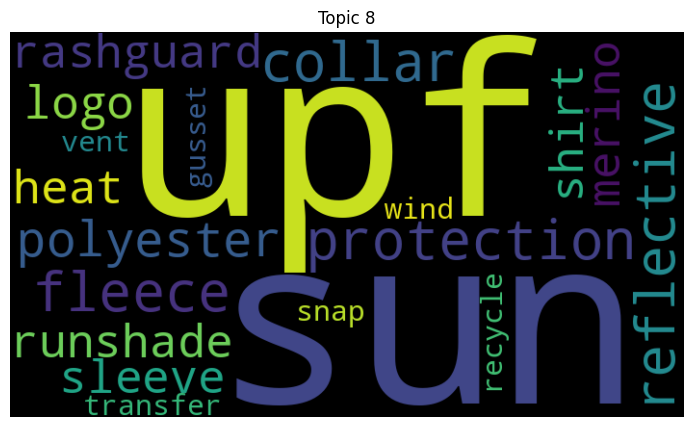

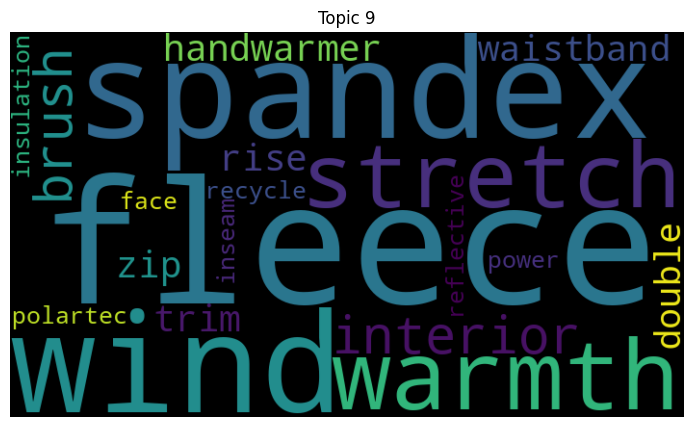

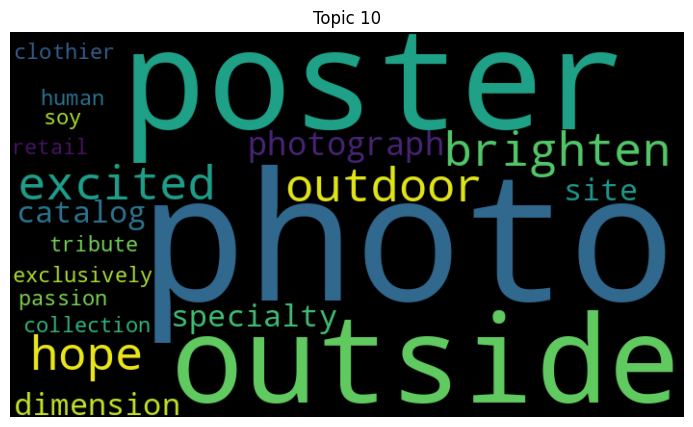

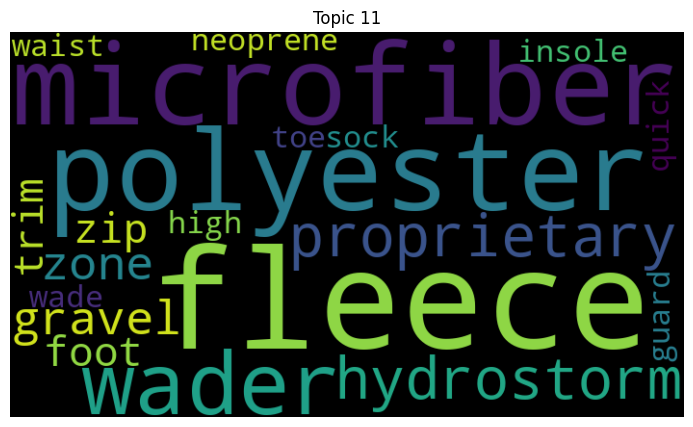

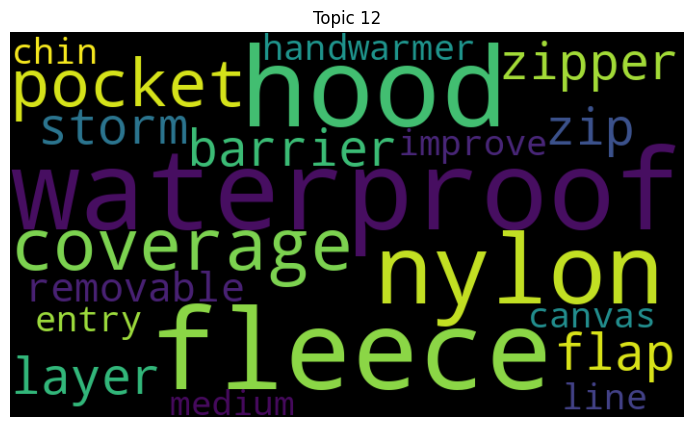

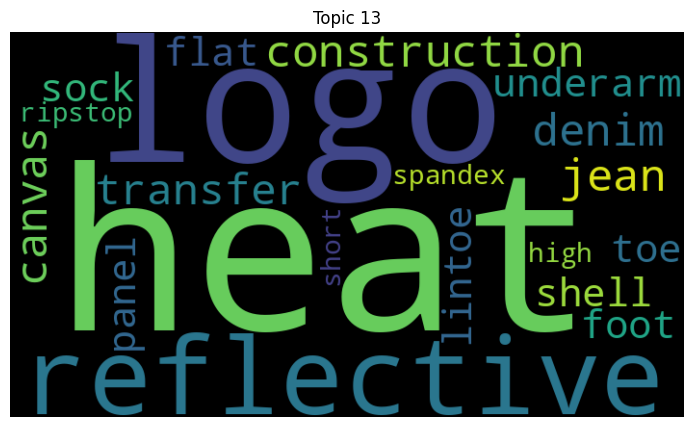

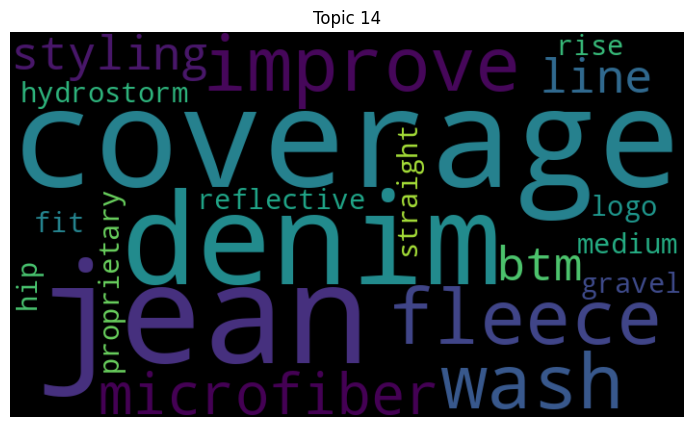

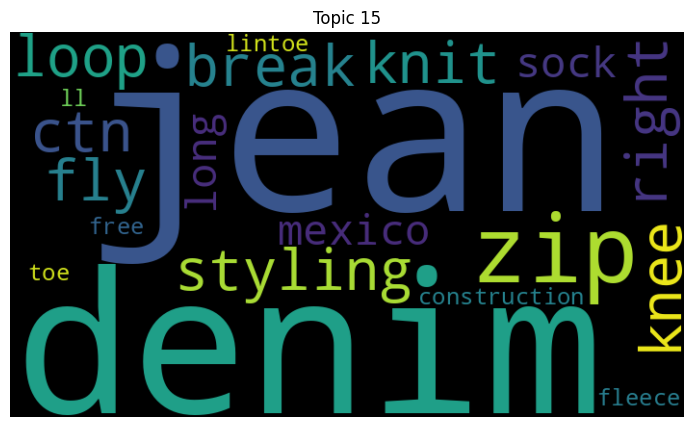

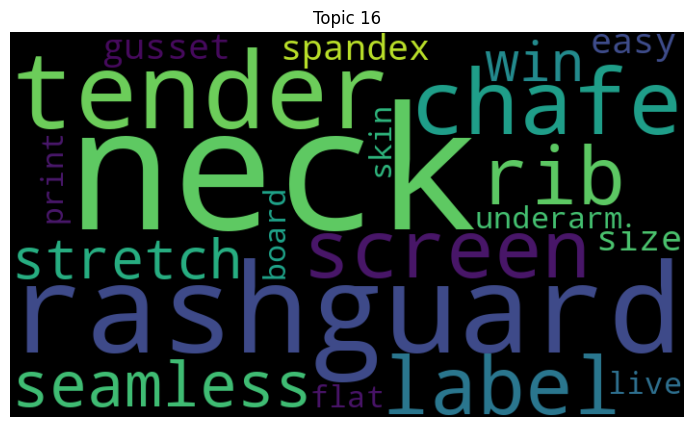

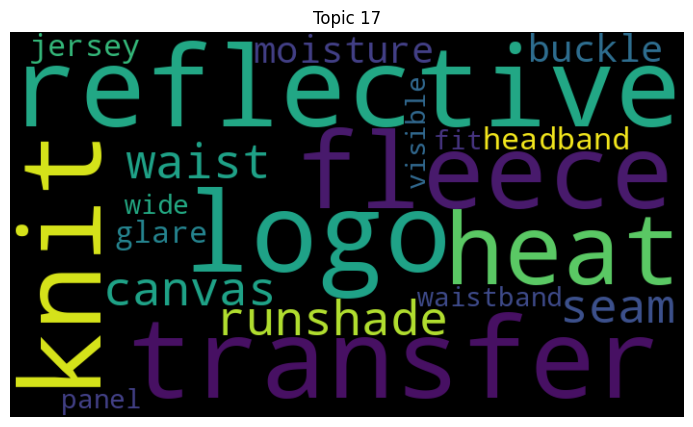

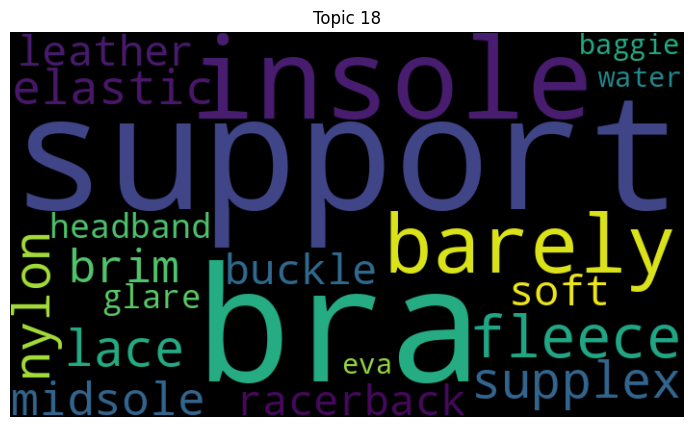

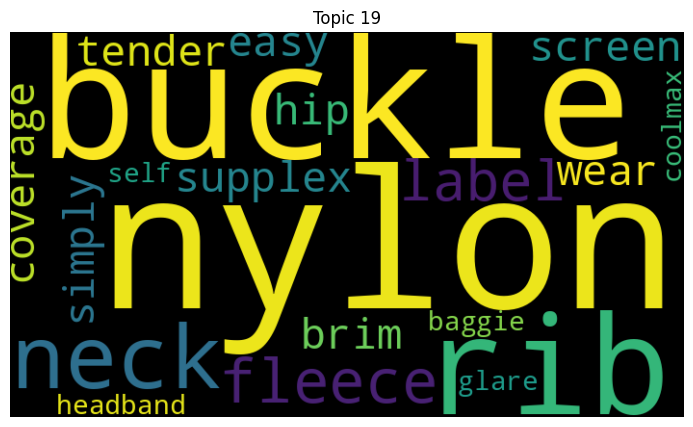

Topic modeling complete. Results saved to products_with_topics.csv.


In [12]:
# Generate word clouds for each topic
terms = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(topic_model.components_):
    topic_words = " ".join([terms[i] for i in topic.argsort()[:-20 - 1:-1]])
    wordcloud = WordCloud(width=700, height=400, background_color='black').generate(topic_words)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Topic {topic_idx}")
    plt.show()

# Save topics assignment
df.to_csv("products_with_topics.csv", index=False)

print("Topic modeling complete. Results saved to products_with_topics.csv.")
